This notebook requires that you have previously run the notebook **Analyze by person** to generate raw data summaries and a timing analysis summary. We assume those files are located in ../processed data/ and have the name prefix "SeattleUgrad"... these variables should be changed in future if this code is used for a different project in a different directory   

In [2]:
%run load_actiwatch_data.py
%run firsttime.py

import matplotlib.pyplot as plt
%matplotlib inline

import pyarrow

from joblib import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

# this is used to make Federal Holidays a nonschool day.  Note that we don't have any
# way to recognize school district unique holidays, like teacher work days of such 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


fileprefix = '../processed data/SeaUgrad'

In [ ]:
allData = pd.read_parquet(fileprefix+'raw.parquet')

In [226]:
# TimingAnaylsis is the more polished and complete version of TimingData
timingData = pd.read_parquet(fileprefix+'TimingAnalysis.parquet', engine='fastparquet')

In [39]:
def map_mins_to_rads(dseries):
    med = dseries.median()
    p25 = dseries.quantile(0.25)
    p75 = dseries.quantile(0.75)    
    if pd.isna(p25) or pd.isna(p75):
        box = []
    else:
        box = [x/1440.0*2*np.pi for x in np.arange(p25,p75)]
    if pd.isna(med):
        med = []
    else:
        med = med/1440.0*2*np.pi

    return (box, med)

def timestamp_to_minutes(ts):
    return ( ts.hour*60.0 + ts.minute + ts.second/60.0)

def tdprint(tim):
    tts = tim.total_seconds()
    h = int(tts/3600.)
    m = int( ( tts - h*3600)/60. )
    return '{:02d}:{:02d}'.format(h,m)


def pandaslides_make_clock_plots( tbg, Thresholds=False, filename='', nosleep=False, offc=0 ):
    sns.set_style("white")
    
    tall = timingData.columns.get_level_values('Threshold')
    
        
    if not Thresholds:
        Thresholds = [5, 50, 500]
        
    if Thresholds=='sleep':
        i=2
        Thresholds=[]
        
    gcols=sns.color_palette('Set2',7)

    boxrad=0.12 
    mw = 2*np.pi/1440
    boxsep = 1.1

    plt.figure(figsize=(5,5))
    ax = plt.subplot(111, projection='polar')

    sunrise=tbg['Sunrise'].median().total_seconds()/60. #.apply(timestamp_to_minutes).median()
    sunset=tbg['Sunset'].median().total_seconds()/60. #.apply(timestamp_to_minutes).median()

    dark=[x/1440.0*2*np.pi for x in np.arange(0,sunrise)]
    ax.bar(dark, np.ones_like(dark), width=0.02, color=[0.4,0.4,0.4], linewidth=0)
    dark=[x/1440.0*2*np.pi for x in np.arange(sunset,1440)]
    ax.bar(dark, np.ones_like(dark), width=0.02, color=[0.4,0.4,0.4], linewidth=0)

    lli=[]
    lll=[]
    for i,thr in enumerate(Thresholds):
        added = False
        #tbgt = tbg.loc[(slice(None)),(slice(None),tall==thr)]
        #print i,thr,tbgt.shape
        onset = tbg[('LightOnset',thr)].dropna().apply( lambda x: x.total_seconds()/60. )
        onm = tdprint( tbg[('LightOnset',thr)].median() )
        ofm = tbg[('LightOffset',thr)].median() 
        if ofm > pd.Timedelta('24 hours'):
            ofm = ofm - pd.Timedelta('24 hours')
        ofm = tdprint(ofm)
        box, med = map_mins_to_rads( onset )
        #print box, med, tbgt['LightOnset']
        ll=ax.bar(box, np.full(len(box), boxrad), width=mw, bottom=1.0-(i+offc+1)*boxrad*boxsep, color=gcols[i+offc], linewidth=0)
        ax.bar(med, boxrad, width=0.02, bottom=1.0-(i+offc+1)*boxrad*boxsep, color=[0.2,0.2,0.2], linewidth=0)
        if (len(ll)>0):
            lli.append(ll)
            lll.append('{:3d} lux {}-{}'.format(thr,onm,ofm))
            added = True
        offset = tbg[('LightOffset',thr)].dropna().apply( lambda x: x.total_seconds()/60. )
        box, med = map_mins_to_rads( offset )
        ll=ax.bar(box, np.full(len(box), boxrad), width=mw, bottom=1.0-(i+offc+1)*boxrad*boxsep, color=gcols[i+offc], linewidth=0)
        ax.bar(med, boxrad, width=0.02, bottom=1.0-(i+offc+1)*boxrad*boxsep, color=[0.2,0.2,0.2], linewidth=0)
        if (len(ll)>0) and (not added):
            lli.append(ll)
            lll.append('{}lx'.format(thr))

    if not nosleep:
        i=2
        box, med = map_mins_to_rads(tbg.SleepOffset.dropna().apply( lambda x: x.total_seconds()/60. ))
        ll=ax.bar(box, np.full(len(box), 1.5*boxrad), width=mw, bottom=1.0-(i+3)*boxrad*boxsep, color=gcols[-2], linewidth=0)
        ax.bar(med, 1.5*boxrad, width=0.02, bottom=1.0-(i+3)*boxrad*boxsep, color=[0.2,0.2,0.2], linewidth=0)
        lli.append(ll)
        onm = tbg.SleepOnset.median()
        if onm > pd.Timedelta('24 hours'):
            onm = onm - pd.Timedelta('24 hours')
        onm = tdprint(onm)
        ofm = tdprint(tbg.SleepOffset.median())
        lll.append('Sleep  {}-{}'.format(onm,ofm) )

        box, med = map_mins_to_rads(tbg.SleepOnset.dropna().apply( lambda x: x.total_seconds()/60. ))
        ll=ax.bar(box, np.full(len(box), 1.5*boxrad), width=mw, bottom=1.0-(i+3)*boxrad*boxsep, color=gcols[-2], linewidth=0)
        ax.bar(med, 1.5*boxrad, width=0.02, bottom=1.0-(i+3)*boxrad*boxsep, color=[0.2,0.2,0.2], linewidth=0)
 #   lli.append(ll)
 #   lll.append('Slept {}'.format(tdprint(tbg.SleepOnset.median())))
    

    thetat = np.arange(0,6)*60
    thetalbl = ['00:00','04:00','08:00','12:00','16:00','20:00']
    ax.set_thetagrids(thetat, labels=thetalbl, frac=1.17)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi)
    ax.set_rticks([])  # less radial ticks
    ax.set_rmax(1.0)
    ax.grid(False)
    #print lli, lll
    plt.legend(lli,lll,loc=[.99,0.01])
    plt.subplots_adjust(right=0.65)
    #nuids = len(tbg.UID.unique())
    #ndays = len(tbg.Date.unique())
    #npds = len(tbg[['UID','Date']].drop_duplicates())
    #wkd = tbg['Weekend/Holiday'].mean()
    #title = "CLASS {}: {} unique persons, {} unique dates, {} person-days, {:3.1f}% weekend".format(grp,nuids,ndays,npds,wkd*100.)
    #ax.set_title(title, loc='left', ha='left', va='center')
    
    if filename:
        plt.savefig(filename,dpi=150)
    plt.show()






In [238]:
timingData

,UID,Date,Threshold,Last Light,Mins to LL from 4AM,First Light,Mins to FL from 4AM,Time above threshold,Time above threshold AM,Minutes above threshold,...,Sunset,Sunrise,hours from sunrise to first light abv threshold,hours from sunset to last light abv threshold,Sleep onset,Sleep offset,Sleep duration,Secondary sleep duration,Sleep onset MSLM,Sleep offset MSLM
index,,,,,,,,,,,,,,,,,,,,,
0,Fall 220 20150034,2015-10-08,5,2015-10-08 23:35:00,1175.0,2015-10-08 05:55:15,115.0,07:14:00,02:10:45,434.00,...,18.630000,7.271389,-1.350556,4.953333,2015-10-09 00:01:30,2015-10-09 05:43:00,05:41:30,0 days,1441.50,343.00
1,Fall 220 20150034,2015-10-11,5,2015-10-11 23:18:45,1158.0,2015-10-11 06:51:45,171.0,05:21:15,01:30:15,321.25,...,18.531667,7.341667,-0.479167,4.780833,2015-10-11 23:47:45,2015-10-12 05:59:30,06:11:45,0 days,1427.75,359.50
2,Fall 220 20150034,2015-10-13,5,2015-10-13 22:38:00,1118.0,2015-10-13 08:21:30,261.0,05:04:45,01:08:45,304.75,...,18.466944,7.389167,0.969167,4.166389,2015-10-14 00:17:45,2015-10-14 05:43:30,05:25:45,0 days,1457.75,343.50
3,Fall 220 20150034,2015-10-15,5,2015-10-15 22:58:15,1138.0,2015-10-15 06:16:15,136.0,07:15:30,02:21:30,435.50,...,18.403333,7.436944,-1.166111,4.567500,2015-10-16 00:07:00,2015-10-16 04:41:30,04:34:30,0 days,1447.00,281.50
4,Fall 220 20150034,2015-10-14,5,2015-10-14 22:53:45,1133.0,2015-10-14 06:20:30,140.0,08:42:30,01:58:15,522.50,...,18.435000,7.413056,-1.071389,4.460833,2015-10-14 23:42:15,2015-10-15 05:24:15,05:42:00,0 days,1422.25,324.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7969,Winter 220 20180041,2018-01-24,1000,2018-01-24 23:31:00,1171.0,2018-01-24 13:35:15,575.0,00:38:15,00:00:00,38.25,...,16.961389,7.745833,5.841667,6.555278,2018-01-25 02:19:15,2018-01-25 11:43:30,09:24:15,0 days,1579.25,703.50
7970,Winter 220 20180041,2018-01-23,1000,NaT,NaN,NaT,NaN,00:00:00,00:00:00,0.00,...,16.936667,7.762222,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN
7971,Winter 220 20180041,2018-01-26,1000,2018-01-26 21:23:30,1043.0,2018-01-26 14:05:15,605.0,01:00:45,00:00:00,60.75,...,17.011667,7.711389,6.376111,4.380000,2018-01-27 01:20:15,2018-01-27 15:04:15,13:44:00,0 days,1520.25,904.25


In [343]:
def tprint(mins):
    h = int(mins/60.)
    m = int( ( mins - h*60) )
    if h>=24.0:
        h = h-24
    return '{:02d}:{:02d}'.format(h,m)

def make_clock_plots( timingData, Groupby, Thresholds=False, figsize=(5,10) ):
    sns.set_style("white")
    
    if not Thresholds:
        Thresholds = timingData.Threshold.unique()
        
    gcols=sns.color_palette('Set2',7)

    boxrad=0.3/len(Thresholds) 
    mw = 2*np.pi/1440
    boxsep = 1.1

    Ng = len(timingData[Groupby].unique())
    f = plt.figure(figsize=figsize)
    
    for gn, grp in enumerate(timingData[Groupby].unique()):
        ax = f.add_subplot(Ng,1,gn+1, projection='polar')
        tbg = timingData[timingData[Groupby]==grp]
        sunrise=(tbg['Sunrise']*60).median() #now its in hours, used to be timestamp #.apply(timestamp_to_minutes).median()
        sunset=(tbg['Sunset']*60).median() #now its in hours, used to be timestamp #.apply(timestamp_to_minutes).median()

        dark=[x/1440.0*2*np.pi for x in np.arange(0,sunrise)]
        ax.bar(dark, np.ones_like(dark), width=0.02, color=[0.42,0.42,0.42], linewidth=0)
        dark=[x/1440.0*2*np.pi for x in np.arange(sunset,1440)]
        ax.bar(dark, np.ones_like(dark), width=0.02, color=[0.42,0.42,0.42], linewidth=0)

        lli=[]
        lll=[]
        for i,thr in enumerate(Thresholds):
            added = False
            tbgt = timingData[(timingData[Groupby]==grp)&(timingData['Threshold']==thr)]
            onset = 4*60+tbgt['Mins to FL from 4AM']
            offset = 4*60+tbgt['Mins to LL from 4AM']
            onbox, onmed = map_mins_to_rads(onset)
            offbox, offmed = map_mins_to_rads(offset)        
            ll=ax.bar(onbox, np.full(len(onbox), boxrad), 
                      width=mw, bottom=1.0-(i+1)*boxrad*boxsep, 
                      color=gcols[i], linewidth=0, alpha=1.)
            _ =ax.bar(onmed, boxrad, 
                      width=0.02, bottom=1.0-(i+1)*boxrad*boxsep, 
                      color=[0.2,0.2,0.2], linewidth=0)
            # for weird small datasets there can be low threshold light onset without offset; 
            # this craziness is to take care of that odd case!
            if (len(ll)>0): 
                lli.append(ll)
                lll.append('{:3d}lx {}-{}'.format(thr, tprint(onset.median()), tprint(offset.median())) )
                added = True
            
            ll=ax.bar(offbox, np.full(len(offbox), boxrad), 
                      width=mw, bottom=1.0-(i+1)*boxrad*boxsep, 
                      color=gcols[i], linewidth=0, alpha=1.)
            _ =ax.bar(offmed, boxrad, 
                      width=0.02, bottom=1.0-(i+1)*boxrad*boxsep, 
                      color=[0.2,0.2,0.2], linewidth=0) 
            if (len(ll)>0) and (not added):
                lli.append(ll)
                lll.append('{}lx'.format(thr))
            
        offset = tbgt['Sleep offset MSLM']
        onset = tbgt['Sleep onset MSLM']
        offbox, offmed = map_mins_to_rads(offset)
        onbox, onmed = map_mins_to_rads(onset)
        p=ax.bar(offbox, np.full(len(offbox), 2*boxrad), 
                  width=mw, bottom=1.0-(i+3)*boxrad*boxsep, 
                  color=gcols[-2], linewidth=0, alpha=1.)
        _ =ax.bar(offmed, 2*boxrad, width=0.02, 
                  bottom=1.0-(i+3)*boxrad*boxsep, 
                  color=[0.2,0.2,0.2], linewidth=0)
        ll=ax.bar(onbox, np.full(len(onbox), 2*boxrad), 
                  width=mw, bottom=1.0-(i+3)*boxrad*boxsep, 
                  color=gcols[-2], linewidth=0, alpha=1.)
        _ =ax.bar(onmed, 2*boxrad, 
                  width=0.02, bottom=1.0-(i+3)*boxrad*boxsep, 
                  color=[0.2,0.2,0.2], linewidth=0)
        lli.append(ll)
        lll.append('Sleep {}-{}'.format(tprint(onset.median()), tprint(offset.median())) )
       

        thetat = np.arange(0,6)*60
        thetalbl = ['00:00','04:00','08:00','12:00','16:00','20:00']
        ax.set_thetagrids(thetat, labels=thetalbl) #with new matplotlib this parameter is gone frac=1.27)
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi)
        ax.set_rticks([])  # less radial ticks
        ax.set_rmax(1.0)
        ax.grid(False)
        
        #if gn+1==Ng:
        ax.legend(lli,lll,loc=[1.01,0.01],prop={'family': 'monospace'})
        
        nuids = len(tbg.UID.unique())
        ndays = len(tbg.Date.unique())
        pdays = len(tbgt[['UID','Date']].drop_duplicates())
        title = "{}={}: {} subjects, {} dates, {} person-days".format(Groupby,grp,nuids,ndays,pdays)
        ax.set_title(title, y = 1.02) #loc='center', ha='center', va='bottom')
        
    plt.subplots_adjust(wspace = 1.2)
        
   





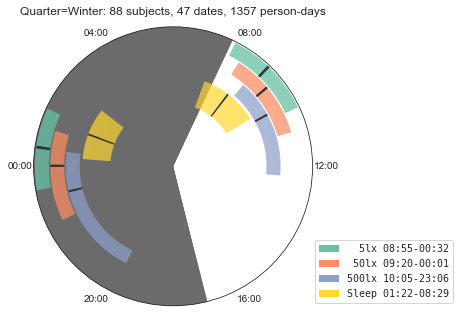

In [344]:
# this is an example of how to make a combine, non-grouped clock plot
make_clock_plots( timingData.query('Quarter == "Winter"'), 'Quarter', Thresholds=[5, 50, 500])

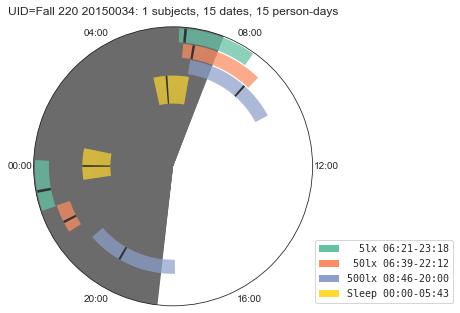

In [345]:
# this is an example of how to make a combine, non-grouped clock plot
make_clock_plots( timingData.query('UID == "Fall 220 20150034"'), 'UID', Thresholds=[5, 50, 500])


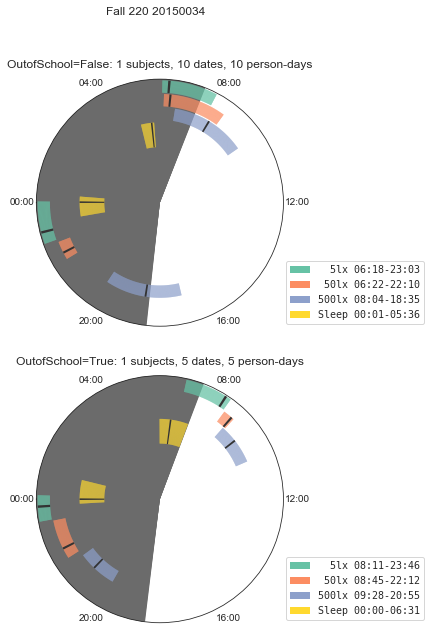

In [346]:
# this is how to make an individuals clock plot
UID = "Fall 220 20150034"
make_clock_plots( timingData.query('UID == @UID'), 'OutofSchool', Thresholds=[5, 50, 500])
plt.suptitle(UID);


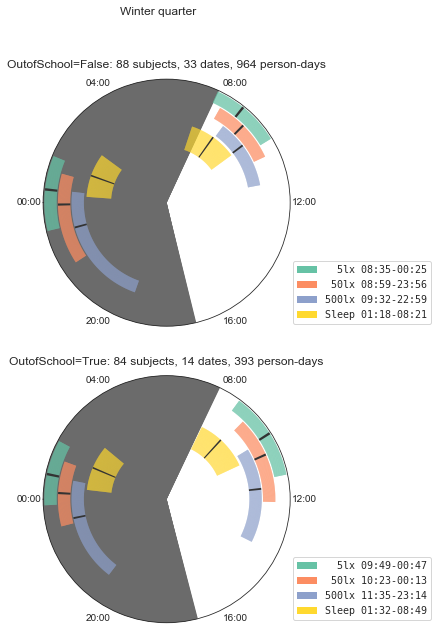

In [347]:
Q = 'Winter'
make_clock_plots( timingData.query('Quarter == @Q'), 'OutofSchool', Thresholds=[5,50,500], figsize=(10,10))
plt.suptitle(Q+' quarter');
#plt.tight_layout()
plt.savefig('../light figures/clockplot-'+Q+'-quarter.png',dpi=300);

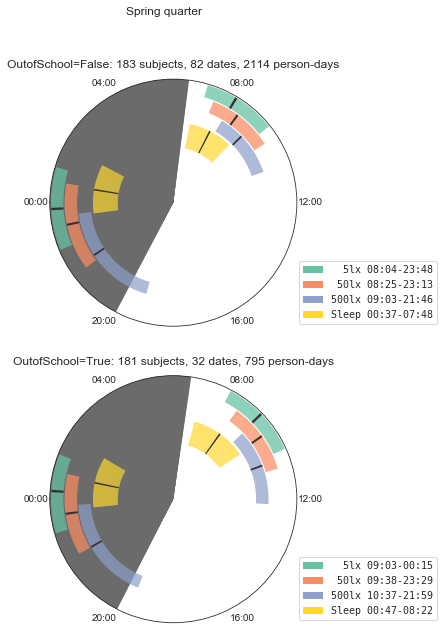

In [348]:
Q = 'Spring'
make_clock_plots( timingData.query('Quarter == @Q'), 'OutofSchool', Thresholds=[5,50,500], figsize=(10,10))
plt.suptitle(Q+' quarter');
plt.savefig('../light figures/clockplot-'+Q+'-quarter.png',dpi=300)

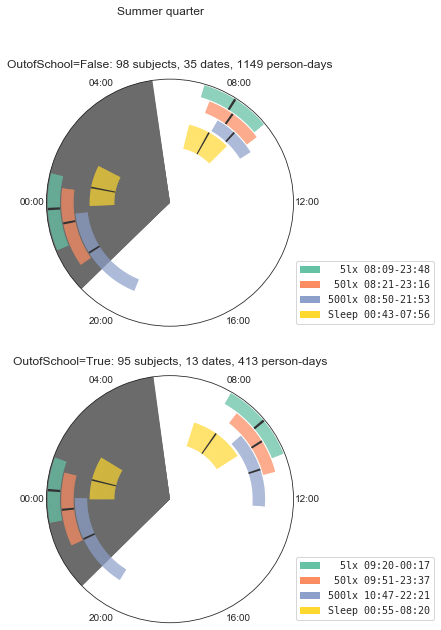

In [349]:
Q = 'Summer'
make_clock_plots( timingData.query('Quarter == @Q'), 'OutofSchool', Thresholds=[5,50,500], figsize=(10,10))
plt.suptitle(Q+' quarter');
plt.savefig('../light figures/clockplot-'+Q+'-quarter.png',dpi=300)

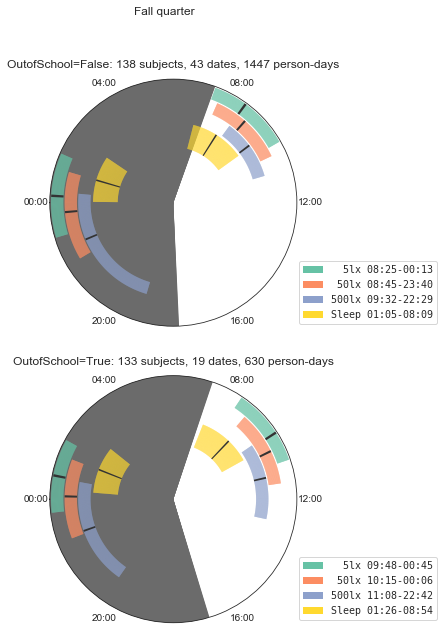

In [350]:
Q = 'Fall'
make_clock_plots( timingData.query('Quarter == @Q'), 'OutofSchool', Thresholds=[5,50,500], figsize=(10,10))
plt.suptitle(Q+' quarter');
plt.savefig('../light figures/clockplot-'+Q+'-quarter.png',dpi=300)